<a href="https://www.kaggle.com/code/yazanjian/mnist-dataset?scriptVersionId=145488227" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# MNIST dataset
In this notebook, we are going to build and evaluate unsupervised algorithms for clustering the given MNIST datset. We also discuss why using clustering algorithms maybe not the smartest idea for this dataset. 

Steps: 
1. Load the dataset as a df. 
2. Check and apply any necessary preprocessing steps such as feature extracting.
3. Build K-means clustering algorithms.
4. Evaluate and analysis.

**Note**: At the end of this notebook you can find the use of KNN classification model to predict.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn import neighbors, metrics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Visualization


In [3]:
# Split the df into x and y for visualization 
y_df = df['label']
x_df = df.drop('label', axis=1)

print("Labels are {}".format(y_df.shape))
print("Values are {}".format(x_df.shape))

Labels are (42000,)
Values are (42000, 784)


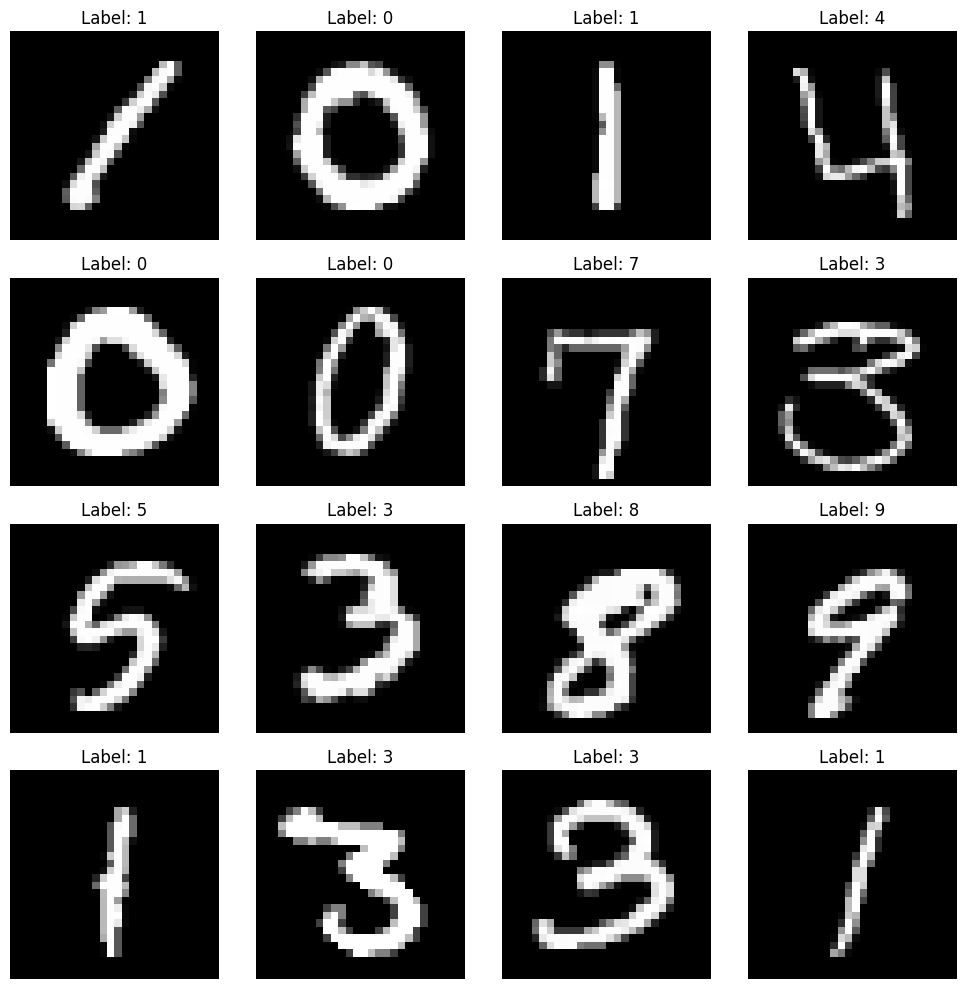

In [4]:
# Visualize the some samples
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = x_df.iloc[i].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {y_df.iloc[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Data Preprocessing
1. Apply feature extraction using PCA 
    * initially, we will not identify the number of features 
    * After visualizing the PCA cumulative score, we will identify the number of PCA components to be used in order to make the eigenvalue (explained_variance_ratio) > 90%

In [5]:
print("Is there any missing data in x_df? {}".format(x_df.isna().any().any()))
print("Is there any missing data in y_df? {}".format(y_df.isna().any().any()))

Is there any missing data in x_df? False
Is there any missing data in y_df? False


In [6]:
x_df.shape

(42000, 784)

In [7]:
# Apply PCA with intially n = the total number of components 
pca = PCA() 
X_df_pca = pca.fit_transform(x_df)

In [8]:
print("The number of PCA components is {}, and the number of features (coef) used to create the components is {}".format(pca.components_.shape[0], pca.components_.shape[1]))
print(pca.explained_variance_)
print(pca.explained_variance_.shape)
print(pca.n_components_)

The number of PCA components is 784, and the number of features (coef) used to create the components is 784
[3.34780591e+05 2.45885065e+05 2.11051627e+05 1.84726373e+05
 1.68070002e+05 1.47773283e+05 1.12534619e+05 9.93154374e+04
 9.50160144e+04 8.06607302e+04 7.20912811e+04 7.07065373e+04
 5.84660489e+04 5.81306660e+04 5.42962167e+04 5.09347636e+04
 4.53183627e+04 4.40491205e+04 4.07953531e+04 3.95858424e+04
 3.68192744e+04 3.48621597e+04 3.31349486e+04 3.13473279e+04
 3.04817757e+04 2.88034132e+04 2.78793025e+04 2.66962785e+04
 2.54335672e+04 2.35801014e+04 2.25952489e+04 2.19364800e+04
 2.05823907e+04 2.02234116e+04 1.93793899e+04 1.85769234e+04
 1.74867897e+04 1.67410231e+04 1.63311550e+04 1.60212450e+04
 1.55544838e+04 1.52810224e+04 1.43629751e+04 1.36504321e+04
 1.32052538e+04 1.28748146e+04 1.23972707e+04 1.19683252e+04
 1.15550626e+04 1.10142157e+04 1.08332078e+04 1.06161236e+04
 1.00860357e+04 9.83989046e+03 9.64133871e+03 9.25875435e+03
 9.12870617e+03 8.80134853e+03 8.71627

In [9]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    plt.axhline(y=0.9, color='r', linestyle='--')
    plt.axvline(x=88, ymax=0.9, color='r', linestyle='--')


    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

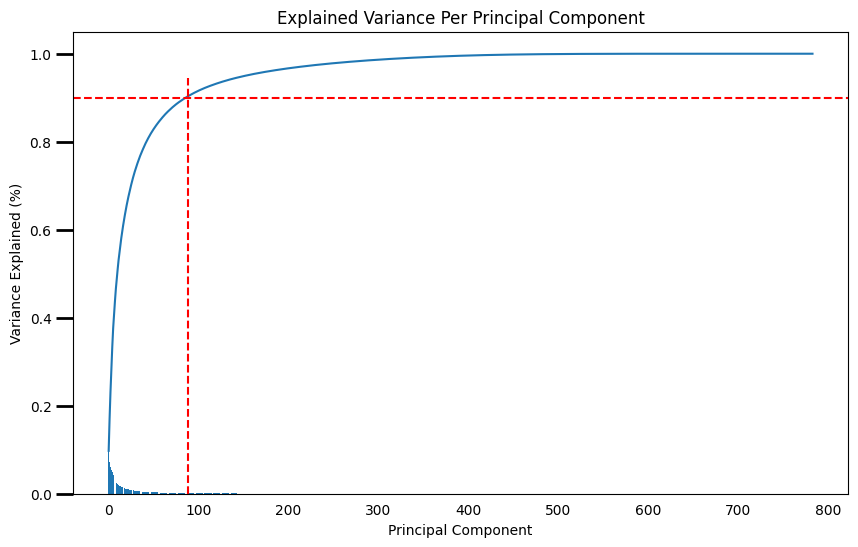

In [10]:
scree_plot(pca)

**Note: Based on the above, choosing n_components=88 for PCA will get us a variance % = 90%**

In [11]:
# Apply PCA with intially n = the total number of components 
pca_88 = PCA(n_components=88) 
X_df_pca_88 = pca_88.fit_transform(x_df)
X_df_pca_88.shape

(42000, 88)

In [12]:
print("The number of PCA components is {}, and the number of features (coef) used to create the components is {}".format(pca_88.components_.shape[0], pca_88.components_.shape[1]))
print(pca_88.explained_variance_)
print(pca_88.explained_variance_.shape)
print(pca_88.n_components_)

The number of PCA components is 88, and the number of features (coef) used to create the components is 784
[334780.59149447 245885.06513832 211051.62698822 184726.37342815
 168070.0015068  147773.28274113 112534.6194561   99315.43743439
  95016.01443297  80660.73018982  72091.28112163  70706.53727732
  58466.04888732  58130.6659581   54296.21671568  50934.76359241
  45318.36268054  44049.12047701  40795.35308491  39585.84242909
  36819.27442151  34862.15962759  33134.94849228  31347.32781535
  30481.7756288   28803.41296077  27879.30236325  26696.27826893
  25433.56692217  23580.10117119  22595.24751444  21936.47931771
  20582.38999364  20223.41111624  19379.38772322  18576.920308
  17486.78011075  16741.00649007  16331.13836986  16021.22324662
  15554.45378273  15280.97408689  14362.92278927  13650.40471892
  13205.20906885  12874.59305075  12397.17416336  11968.2470168
  11554.6072352   11014.05955887  10833.01982895  10615.61599322
  10085.48083494   9839.261174     9640.34439032   

# Model Training
1. Train K-means model 
2. Train DMM model 

### K-means Clustering
**In this section several steps will be taken into consideration as follows: 
**1. Although we already know that we have 10 different digits, we will be using the elbow method to analyze if it would corrolate with 10 clusters choice.   
2. Using the PCA with the chosen number of components to fit a k-means model with n=10
3. Evaluate the model using three different evaluation metrics: silhouette score, adjusted rand score (ARM) and normalized mutual info score (MIS). The ARM and MIS would be suitable in our case as we have the original label of each digit. 
4. Visual Evaluation by comparing the real image with the predicted cluster.

In [13]:
# The number of unique values in lables
sorted_y = sorted(y_df.unique())
print(sorted_y)
print("We have {} different clusters".format(len(sorted_y)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
We have 10 different clusters


In [14]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    print("Finish calculations for k-means with {} clusters".format(center))
    return score    

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Finish calculations for k-means with 1 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Finish calculations for k-means with 4 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Finish calculations for k-means with 7 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Finish calculations for k-means with 10 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Finish calculations for k-means with 13 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Finish calculations for k-means with 16 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Finish calculations for k-means with 19 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Finish calculations for k-means with 22 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Finish calculations for k-means with 25 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Finish calculations for k-means with 28 clusters


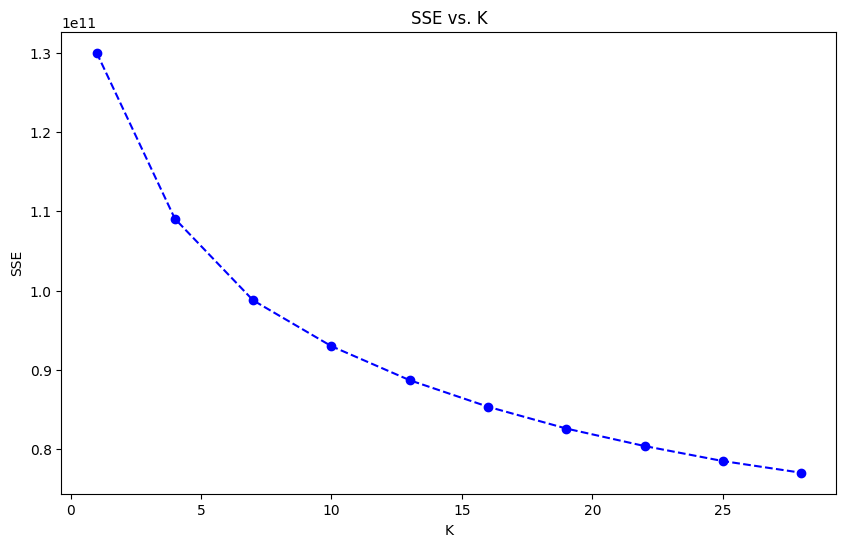

In [15]:
scores = []
centers = list(range(1,30,3)) 

for center in centers:
    scores.append(get_kmeans_score(X_df_pca_88, center))

plt.figure(figsize=(10, 6));
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

**Note: Although we used the above method to check the best number of clusters, we don't need to apply such method in our case as we already know that there are only 10 possible clusters.**

In [16]:
X_df_pca_88.shape

(42000, 88)

Train a k-means model with n=10 on the transformed PCA using 88 components.

In [17]:
#Train a k-means model with n=10
kmeans = KMeans(n_clusters=10, random_state=42)
# Then fit the model to your data using the fit method
model = kmeans.fit(X_df_pca_88)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [18]:
model.predict(X_df_pca_88)

array([7, 0, 3, ..., 1, 2, 4], dtype=int32)

#### Evaluation
In this section we will utilize 3 different evaluation metrics for clustering using k-means: 
1. **The Silhouette Score** is a metric used to calculate the goodness of a clustering technique, like K-means clustering. It provides a way to measure how well-defined the clusters in your data are. Specifically, it quantifies how similar an object is to its own cluster compared to other clusters. The Silhouette Score ranges from -1 to 1. A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
2.  **The Adjusted Rand Index (ARI)** is a measure used to evaluate the similarity between two clusterings. It assesses the agreement between the true labels and the labels predicted by a clustering algorithm, while taking into account the possibility of labels being assigned by chance. The ARI produces a value between -1 and 1. A high positive value indicates a strong agreement between the true labels and the predicted labels, while a negative or close-to-zero value suggests that the agreement is no better than random chance.
3. **The Normalized Mutual Information (NMI)** is a measure used to evaluate the similarity between two clusterings. It quantifies the amount of information shared by two clusterings, while taking into account the possibility of labels being assigned by chance. The NMI produces a value between 0 and 1. A high value indicates a strong agreement between the true labels and the predicted labels, while a low value suggests less similarity.

In [19]:
silhouette_score(X_df_pca_88, model.labels_)

0.07251461174597867

In [20]:
#Calculate ARI score
adjusted_rand_score(y_df, model.labels_)

0.3617444688894821

In [21]:
#Calculate the NMI score
normalized_mutual_info_score(y_df, model.labels_)

0.4916281959736068

We can notice the low score value of silhouette_score. However, when we use the true labels to verify the performance using ARM and NMI metrics we can indicate that the model could indeed predict the digits to a good extent.

In the following section, we are going to first map each cluster to its true label by utilizing linear_sum_assignment optimizer which relies on the Hungarian algorithm to find the best mapping. Then we will visually verify the ability for the model to predict some digits. 

Text(0.5, 0, 'Predicted label')

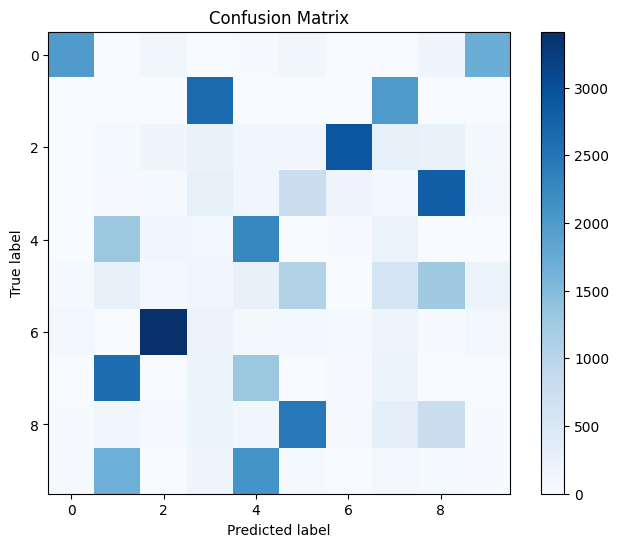

In [22]:
# Create a confusion matrix between true labels and cluster labels
conf_matrix = confusion_matrix(y_df, kmeans.labels_)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
# Add titles and labels
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

**Note:** Based on the above confusion matirx we can notice that some of the true labels for example 1 labels, are splitted into two clusters (Cluster 1 and 6). Others like cluster 7 is able to identify and contains most the digits equals to 6. Hence, base on this visulization, we can conclude that digits 2, 3 and 6 most likely will be predicted correctly. However, digits 0, 1 and others may result with incorrect digits.

In [23]:
# Find the optimal mapping between cluster labels and true labels using the Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(-conf_matrix)

# Create a dictionary to map cluster labels to original labels
cluster_to_original_mapping = {col: row for col, row in zip(col_ind, row_ind)}

# Use the mapping to get the cluster labels with the same names as original labels
cluster_labels_with_original_names = [cluster_to_original_mapping[label] for label in kmeans.labels_]

In [24]:
print('The mapping between the clusters and the true labels is: {}'.format(cluster_to_original_mapping))

The mapping between the clusters and the true labels is: {0: 0, 3: 1, 6: 2, 8: 3, 4: 4, 7: 5, 2: 6, 1: 7, 5: 8, 9: 9}


In [25]:
# Visualize the some samples
def plot_index(i):
    plt.figure(figsize=(2, 2))
    img = x_df.iloc[i].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(f'True Label: {y_df.iloc[i]}, Predicted Cluster: {cluster_to_original_mapping[model.labels_[i]]}')
    plt.axis('off')   

    plt.tight_layout()
    plt.show()

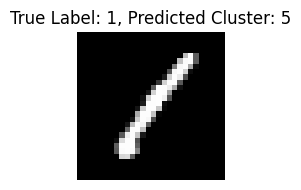

In [26]:
plot_index(0)

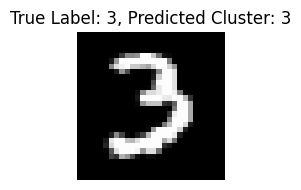

In [27]:
plot_index(9)

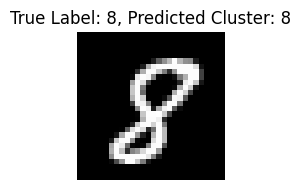

In [28]:
plot_index(105)

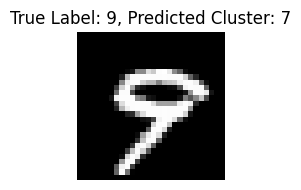

In [29]:
plot_index(121)

# Cluster and predict test data

(28000, 784)


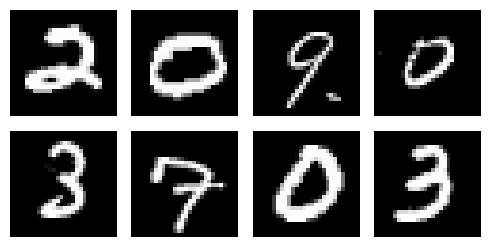

Silhouette Score 0.0727570933390685


In [30]:
# 1. Read the data
x_df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
print(x_df_test.shape)

# 2. Visualize some samples
plt.figure(figsize=(5, 5))
for i in range(8):
    plt.subplot(4, 4, i+1)
    img = x_df_test.iloc[i].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

#3. Apply PCA with n = 88
x_df_test_pca_88 = pca_88.transform(x_df_test)

#4. Prediction 
predictions = model.predict(x_df_test_pca_88)

#5. Evaluation
print('Silhouette Score {}'.format(silhouette_score(x_df_test_pca_88, predictions)))

#6. Map to original Labels
original_labels = [cluster_to_original_mapping[predicted_label] for predicted_label in predictions]

In [31]:
output_data = {'ImageId': x_df_test.index.values + 1, 'Label': original_labels}

output_data_df = pd.DataFrame(output_data)
output_data_df.head()

output_data_df

,ImageId,Label
0,1,2
1,2,0
2,3,7
3,4,7
4,5,2
...,...,...
27995,27996,4
27996,27997,4
27997,27998,3
27998,27999,4


(-0.5, 27.5, 27.5, -0.5)

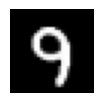

In [32]:
plt.figure(figsize=(5, 5))
plt.subplot(4, 4, i+1)
img = x_df_test.iloc[27995].values.reshape(28,28)
plt.imshow(img, cmap='gray')
plt.axis('off')

In [33]:
# Export DataFrame to CSV
output_data_df.to_csv('output.csv', index=False)

# Discussion 
Since most of the digits has more than one possible cluster to be set to, and since we are using a static method of mapping each cluster to its correspondence real digit value, we noticed that the score of using such method is low, around 51% (when submitting the output file). Moreover, if we check the confusion matrix we will notice cluster 1 has limitations distinguishing between digit 4 and 9 (in fact, hand written digits of 4 and 9 may look similar).  Hence, such clustering method is better for recommendation or to understand the similarities between the different classes. 

It is good mentioning that other clustering methods such as GMM may work better. (To be developed in the future)

In the following section we are going to use classification method to solve the problem in hand. 

# Classification Model training
In this section we will use k-nearest neighbor

In [34]:
y_df = df['label']
x_df = df.drop('label', axis=1)

In [35]:
model = neighbors.KNeighborsClassifier(n_neighbors = 3)

model.fit(x_df, y_df)

KNeighborsClassifier(n_neighbors=3)

In [36]:
predicted_labels = model.predict(x_df)

In [37]:
accuracy = metrics.accuracy_score(y_df, predicted_labels)

# Calculate precision
precision = metrics.precision_score(y_df, predicted_labels, average = "weighted")

# Calculate recall
recall = metrics.recall_score(y_df, predicted_labels, average = "weighted")

# Calculate F1-score
f1 = metrics.f1_score(y_df, predicted_labels, average = "weighted")

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9837619047619047
Precision: 0.9838351871971023
Recall: 0.9837619047619047
F1 Score: 0.9837483542140071


In [38]:
x_df_test_KNN = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
y_df_KNN_prediction = model.predict(x_df_test_KNN)

In [39]:
output_data_KNN = {'ImageId': x_df_test_KNN.index.values + 1, 'Label': y_df_KNN_prediction}

output_data_KNN_df = pd.DataFrame(output_data_KNN)


# Export DataFrame to CSV
output_data_KNN_df.to_csv('output_KNN.csv', index=False)

In [40]:
output_data_KNN_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
